In [1]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
#import random
import math
import spectral
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

#import warnings; warnings.simplefilter('ignore')

#Global parameters
rpca_n_components = 30
patch_size = 5

test_fraction = 0.2
n_samples = 350
learning_rate = 0.007

epochs = 1501
batch_size = 200

In [2]:
print(tf.__version__)

1.1.0


In [3]:
input_mat= scipy.io.loadmat('Indian_pines.mat')['indian_pines']
groundtruth_mat = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [4]:
print("Input shape:", input_mat.shape, "Input data type:", input_mat.dtype)

Input shape: (145, 145, 220) Input data type: uint16


In [5]:
n_classes = len(np.unique(groundtruth_mat)) - 1
print("Number of classes: ", n_classes)

Number of classes:  16


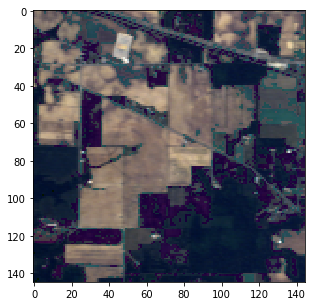

In [6]:
image = spectral.imshow(input_mat, bands=(29, 19, 9), figsize = (5,5))

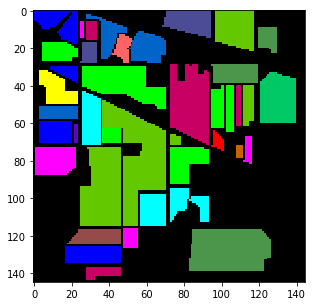

In [7]:
ground_truth = spectral.imshow(classes = groundtruth_mat, figsize = (5,5))

In [8]:
hight = input_mat.shape[0]
width = input_mat.shape[1]
band = input_mat.shape[2]

print("hight:", hight, " width:", width, " band:", band)

hight: 145  width: 145  band: 220


In [9]:
#reduce dimensions based on rpca_n_compoonents
print(input_mat.shape)

input_mat_1D = np.reshape(input_mat, (-1, input_mat.shape[2]))

print(input_mat_1D.shape)

rpca = RandomizedPCA(n_components=rpca_n_components, whiten=False)
input_mat_1D_reduced = rpca.fit_transform(input_mat_1D)
input_mat_reduced = np.reshape(input_mat_1D_reduced, (input_mat.shape[0], input_mat.shape[1], -1))

print("Current shape: ", input_mat_reduced.shape)
print("Explained variance ratio is: ", rpca.explained_variance_ratio_.sum())

(145, 145, 220)
(21025, 220)
Current shape:  (145, 145, 30)
Explained variance ratio is:  0.987158


/Users/Zhusparker/miniconda3/envs/EE259/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [10]:
input_mat_reduced[0][0]

array([  5.01488721e+03,   1.45685364e+03,   7.27811661e+01,
         7.11239624e+01,  -4.35633820e+02,   6.89358444e+01,
         1.34665009e+02,  -3.05297058e+02,   2.55709000e+02,
        -6.54384232e+01,  -1.26796799e+02,  -2.92874660e+01,
        -1.14766617e+02,   1.88148880e+02,  -1.36285904e+02,
         1.93718185e+02,   4.64446297e+01,   3.95771576e+02,
        -1.21275322e+02,  -2.20229416e+02,  -4.04168653e+00,
         7.72825394e+01,   6.53893890e+01,  -1.19448967e+02,
        -5.29403267e+01,  -2.60610256e+01,   1.07849945e+02,
         4.23238659e+00,  -3.49732285e+01,   3.99435272e+01], dtype=float32)

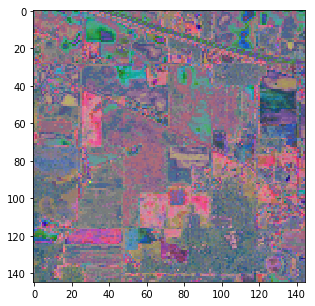

In [11]:
image = spectral.imshow(input_mat_reduced, bands=(5, 10, 20), figsize = (5,5))

In [12]:
input_mat_reduced.dtype

dtype('float32')

In [13]:
#dimensions reduced 
#scale the value to [0, 1]

#input_mat_reduced = input_mat_reduced.astype(np.float32)
#print(input_mat_reduced.dtype)
for i in range(rpca_n_components):
    
    input_mat_reduced[:, :, i] = (input_mat_reduced[:, :, i] - np.min(input_mat_reduced[:, :, i])) / (np.max(input_mat_reduced[:, :, i]) - np.min(input_mat_reduced[:, :, i]))
    
print(input_mat_reduced.dtype)
print(input_mat_reduced[0][0])

float32
[ 0.66223258  0.53276378  0.24729455  0.36577642  0.23754717  0.52623278
  0.50720447  0.35323223  0.44888595  0.39720044  0.42284349  0.4622871
  0.4532446   0.45912576  0.37631008  0.49723604  0.46275923  0.52759737
  0.47074443  0.28548238  0.51963133  0.59127319  0.50453109  0.40359592
  0.48974535  0.5035758   0.59256423  0.51860195  0.49867478  0.46581927]


In [14]:
#scale the value from 0 to 1

#input_mat = input_mat.astype(float)
#input_mat -= np.min(input_mat)
#input_mat /= np.max(input_mat)

#print(input_mat.dtype)

In [15]:
#normalized the value

#mean_array = np.ndarray(shape=(band,),dtype=float32)
#for i in range(band):
#    mean_array[i] = np.mean(input_mat[:,:,i])
#    input_mat[:,:,i] -= mean_array[i]

In [16]:
#without transposing for now

#test = np.transpose(input_mat,(2,0,1))

#print(test.dtype)
#print(test.shape)

In [17]:
#decompose based on the patch_size

lower = int(math.floor(patch_size / 2))
upper = int(math.ceil(patch_size / 2))

print("lower:", lower)
print("upper:", upper)

def decompose(x,y):
    height_slice = slice(x - lower, x + upper)
    width_slice = slice(y - lower, y + upper)
    patch = input_mat_reduced[height_slice, width_slice, :]
    
    return np.array(patch)

lower: 2
upper: 3


In [18]:
test = decompose(2, 2)
print(test[0][0])
print(groundtruth_mat[2, 2])

[ 0.66223258  0.53276378  0.24729455  0.36577642  0.23754717  0.52623278
  0.50720447  0.35323223  0.44888595  0.39720044  0.42284349  0.4622871
  0.4532446   0.45912576  0.37631008  0.49723604  0.46275923  0.52759737
  0.47074443  0.28548238  0.51963133  0.59127319  0.50453109  0.40359592
  0.48974535  0.5035758   0.59256423  0.51860195  0.49867478  0.46581927]
3


In [19]:
classes = []
for i in range(n_classes):
    classes.append([])

In [20]:
for i in range(lower, hight - upper + 1):
    for j in range(lower, width - upper + 1):
        curr_inp = decompose(i,j)
            
        curr_tar = groundtruth_mat[i, j]
        if(curr_tar != 0): 
            classes[curr_tar-1].append(curr_inp)

In [21]:
#ith class, jth patch, y-axle, x-axle
print(classes[2][0][0][0])

[ 0.66223258  0.53276378  0.24729455  0.36577642  0.23754717  0.52623278
  0.50720447  0.35323223  0.44888595  0.39720044  0.42284349  0.4622871
  0.4532446   0.45912576  0.37631008  0.49723604  0.46275923  0.52759737
  0.47074443  0.28548238  0.51963133  0.59127319  0.50453109  0.40359592
  0.48974535  0.5035758   0.59256423  0.51860195  0.49867478  0.46581927]


In [22]:
for i in classes:
    print(len(i))

46
1428
777
237
468
730
28
478
20
967
2413
593
205
1265
338
93


In [23]:
train_patch, train_label, test_patch, test_label = [], [], [], []

test_count = 0
for i in range(n_classes):
    #print(i)
    test_size = int(len(classes[i])*test_fraction)
    test_count +=test_size
    
    patches = classes[i]
    patches = shuffle(patches)
    
    train_patch.append(patches[:-test_size])
        
    test_patch.extend(patches[-test_size:])
    test_label.extend(np.full(test_size, i, dtype=np.int8))

print("num of test:", test_count)
    
for i in range(n_classes):
    if(len(train_patch[i]) < n_samples):
        tmp = train_patch[i]
        for j in range(int(n_samples/len(train_patch[i]))):
            #print("test", j)
            train_patch[i] = shuffle(train_patch[i])
            train_patch[i] += tmp
    train_patch[i] = shuffle(train_patch[i])
    train_patch[i] = train_patch[i][:n_samples]
    print(i)

num of test: 2011
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [24]:
for i in train_patch:
    print(len(i))

350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350


In [25]:
print(len(test_patch))

2011


In [26]:
print(train_patch[0][0].shape)
train_patch = np.asarray(train_patch)
print(train_patch.shape)
train_patch = train_patch.reshape((-1,patch_size, patch_size, rpca_n_components))
print(train_patch.shape)
print(train_patch[2][0][0])

(5, 5, 30)
(16, 350, 5, 5, 30)
(5600, 5, 5, 30)
[ 0.54802221  0.49740803  0.13542698  0.28519577  0.37171564  0.41573668
  0.4231472   0.59818119  0.18780367  0.3455618   0.5372414   0.32700521
  0.4078666   0.3583312   0.42271018  0.63239288  0.409987    0.33687854
  0.5281592   0.27255204  0.58915627  0.61813968  0.38482529  0.56537259
  0.54805243  0.5420301   0.61895794  0.48271945  0.64138877  0.39377618]


In [27]:
train_label = np.array(train_label)
for i in range(n_classes):
    train_label = np.append(train_label, np.full(n_samples, i, dtype=np.int8))

In [28]:
train_label.dtype

dtype('float64')

In [29]:
train_label = train_label.astype(np.uint8)

In [30]:
train_label.shape

(5600,)

In [31]:
train_label

array([ 0,  0,  0, ..., 15, 15, 15], dtype=uint8)

In [32]:
train_patch.dtype

dtype('float32')

In [33]:
train_patch

array([[[[ 0.6714499 ,  0.53854519,  0.20112182, ...,  0.64277273,
           0.72345668,  0.43787506],
         [ 0.55523896,  0.50149149,  0.15240866, ...,  0.39387003,
           0.59352136,  0.36633763],
         [ 0.45434466,  0.45890489,  0.10374192, ...,  0.51985443,
           0.5283072 ,  0.41019884],
         [ 0.45293653,  0.45744795,  0.08200742, ...,  0.58346641,
           0.6008864 ,  0.5706864 ],
         [ 0.4348031 ,  0.4570176 ,  0.06435929, ...,  0.51457018,
           0.65309137,  0.50799954]],

        [[ 0.68792981,  0.48399752,  0.20710197, ...,  0.48442531,
           0.48356244,  0.40532529],
         [ 0.56565243,  0.46196991,  0.13364586, ...,  0.59439647,
           0.60508281,  0.39672637],
         [ 0.44788161,  0.45339504,  0.09987682, ...,  0.60940123,
           0.54151416,  0.43154436],
         [ 0.44642645,  0.45513248,  0.08072462, ...,  0.53894013,
           0.55798721,  0.4921267 ],
         [ 0.43915355,  0.45897493,  0.07534267, ...,  0.41413

In [34]:
assert(len(train_patch) == len(train_label))
assert(len(test_patch) == len(test_label))

In [35]:
#wrong
#=============

'''
for i in range(int(len(train_patch)/(n_samples * 2))):
    train_dict = {}
    start = i * (n_samples * 2)
    end = (i + 1) * (n_samples * 2)
    file_name = 'Train_'+str(patch_size)+'_'+str(i+1)+'.mat'
    train_dict["train_patch"] = train_patch[start:end]
    train_dict["train_label"] = train_label[start:end]
    scipy.io.savemat(file_name,train_dict)
    #print(i)
'''    
#print(train_dict)

'\nfor i in range(int(len(train_patch)/(n_samples * 2))):\n    train_dict = {}\n    start = i * (n_samples * 2)\n    end = (i + 1) * (n_samples * 2)\n    file_name = \'Train_\'+str(patch_size)+\'_\'+str(i+1)+\'.mat\'\n    train_dict["train_patch"] = train_patch[start:end]\n    train_dict["train_label"] = train_label[start:end]\n    scipy.io.savemat(file_name,train_dict)\n    #print(i)\n'

In [36]:
#wrong
#=============

'''
for i in range(int(len(test_patch)/(n_samples * 2))):
    test_dict = {}
    start = i * (n_samples * 2)
    end = (i + 1) * (n_samples * 2)
    file_name = 'Test_'+str(patch_size)+'_'+str(i+1)+'.mat'
    test_dict["test_patch"] = test_patch[start:end]
    test_dict["test_label"] = test_label[start:end]
    scipy.io.savemat(file_name,train_dict)
    #print(i)
'''

'\nfor i in range(int(len(test_patch)/(n_samples * 2))):\n    test_dict = {}\n    start = i * (n_samples * 2)\n    end = (i + 1) * (n_samples * 2)\n    file_name = \'Test_\'+str(patch_size)+\'_\'+str(i+1)+\'.mat\'\n    test_dict["test_patch"] = test_patch[start:end]\n    test_dict["test_label"] = test_label[start:end]\n    scipy.io.savemat(file_name,train_dict)\n    #print(i)\n'

In [37]:
def init_weights(shape, mean, stddev):
    init_random_dist = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    return tf.Variable(init_random_dist)

In [38]:
def init_bias(shape, val):
    init_bias_vals = tf.constant(val, shape=shape)
    return tf.Variable(init_bias_vals)

In [39]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

In [40]:
def convolutional_layer(input_x, shape, mean, stddev, val):
    W = init_weights(shape, mean, stddev)
    b = init_bias([shape[3]], val)
    return tf.nn.relu(conv2d(input_x, W) + b)

In [41]:
def normal_full_layer(input_layer, num_units, mean, stddev, val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, num_units], mean, stddev)
    b = init_bias([num_units], val)
    return tf.nn.relu(tf.matmul(input_layer, W) + b)

In [42]:
def Mymodel(images, conv1_channels, conv2_channels, f1_units):
    mu = 0.0
    sigma = 0.1
    const_val = 0.1
    
    print(images.shape)
    
    #conv1, input = 5x5x30, output = 3x3x(30x3), no pooling
    conv1 = convolutional_layer(images, [3, 3, rpca_n_components, conv1_channels], mu, sigma, const_val)
    
    #conv2, input = 3x3x(30x3), output = 1x1x(30x3x3), no pooling
    conv2 = convolutional_layer(conv1, [3, 3, conv1_channels, conv2_channels], mu, sigma, const_val)  
    
    #flatten, input = 1x1x(30x3x3), output = (30x3x3)
    #f0 = flatten(conv2)
    f0 = tf.reshape(conv2, shape=[-1, rpca_n_components * 3 * 3])
    
    #hidden layer, input = (30x3x3), output = (30x6)
    f1 = normal_full_layer(f0, f1_units, mu, sigma, const_val)
    
    #output
    logits = normal_full_layer(f1, n_classes, mu, sigma, const_val)
    
    return logits

In [43]:
print(train_patch.shape)
print(train_label.shape)

(5600, 5, 5, 30)
(5600,)


In [51]:


x = tf.placeholder(tf.float32, (None, patch_size, patch_size, rpca_n_components))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

print(one_hot_y)

logits = Mymodel(x, rpca_n_components * 3, rpca_n_components * 3 * 3, rpca_n_components * 6)
    
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

training_operation = optimizer.minimize(loss_operation)

init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


# Training with all batches


def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset: offset + batch_size], y_data[offset: offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training_acc_seq, Validation_acc_seq, num_of_epoch = [], [], []

with tf.Session() as sess:
    sess.run(init)
    num_examples = len(train_patch)
    
    print("Training...")
    print()
    for i in range(epochs):
        #combined = list(zip(train_patch, train_label))
        #random.shuffle(combined)

        #train_patch[:], train_label[:] = zip(*combined)
        
        #train_patch, train_label = shuffle(train_patch, train_label)
        
        #print(train_patch.shape)
        #print(train_label.shape)
        
        train_patch, train_label = shuffle(train_patch, train_label)
        
        #sess.run(training_operation, feed_dict = {x: train_patch, y: train_label})
        
        
        for offset in range(0, num_examples, batch_size):
            end = offset + batch_size
            batch_x, batch_y = train_patch[offset: end], train_label[offset: end]
            #print(batch_y)
            sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y})
            #train_cur_acc = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y})
            #print(train_cur_acc)
        
        
        if i%10 == 0:
            test_patch, test_label = shuffle(test_patch, test_label)
            validation_accuracy = evaluate(test_patch, test_label)
            Training_accuracy = evaluate(train_patch, train_label)
            
            Training_acc_seq.append(Training_accuracy * 100)
            Validation_acc_seq.append(validation_accuracy * 100)
            num_of_epoch.append(i)
            #validation_accuracy = sess.run(accuracy_operation, feed_dict={x: test_patch, y: test_label})
            print("EPOCH {} ...".format(i))
            print("Training Accuracy = {:.3f}".format(Training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()
    
    saver.save(sess, './modelone')
    print("Model saved")

Tensor("one_hot_6:0", dtype=float32)
(?, 5, 5, 30)
Training...

EPOCH 0 ...
Training Accuracy = 0.126
Validation Accuracy = 0.137

EPOCH 10 ...
Training Accuracy = 0.240
Validation Accuracy = 0.266

EPOCH 20 ...
Training Accuracy = 0.315
Validation Accuracy = 0.274

EPOCH 30 ...
Training Accuracy = 0.340
Validation Accuracy = 0.308

EPOCH 40 ...
Training Accuracy = 0.348
Validation Accuracy = 0.276

EPOCH 50 ...
Training Accuracy = 0.366
Validation Accuracy = 0.313

EPOCH 60 ...
Training Accuracy = 0.364
Validation Accuracy = 0.317

EPOCH 70 ...
Training Accuracy = 0.378
Validation Accuracy = 0.324

EPOCH 80 ...
Training Accuracy = 0.374
Validation Accuracy = 0.328

EPOCH 90 ...
Training Accuracy = 0.388
Validation Accuracy = 0.334

EPOCH 100 ...
Training Accuracy = 0.382
Validation Accuracy = 0.326

EPOCH 110 ...
Training Accuracy = 0.394
Validation Accuracy = 0.367

EPOCH 120 ...
Training Accuracy = 0.410
Validation Accuracy = 0.368

EPOCH 130 ...
Training Accuracy = 0.412
Validation

EPOCH 1180 ...
Training Accuracy = 0.617
Validation Accuracy = 0.560

EPOCH 1190 ...
Training Accuracy = 0.616
Validation Accuracy = 0.561

EPOCH 1200 ...
Training Accuracy = 0.614
Validation Accuracy = 0.577

EPOCH 1210 ...
Training Accuracy = 0.616
Validation Accuracy = 0.566

EPOCH 1220 ...
Training Accuracy = 0.617
Validation Accuracy = 0.556

EPOCH 1230 ...
Training Accuracy = 0.616
Validation Accuracy = 0.559

EPOCH 1240 ...
Training Accuracy = 0.617
Validation Accuracy = 0.555

EPOCH 1250 ...
Training Accuracy = 0.617
Validation Accuracy = 0.556

EPOCH 1260 ...
Training Accuracy = 0.617
Validation Accuracy = 0.558

EPOCH 1270 ...
Training Accuracy = 0.617
Validation Accuracy = 0.556

EPOCH 1280 ...
Training Accuracy = 0.615
Validation Accuracy = 0.564

EPOCH 1290 ...
Training Accuracy = 0.617
Validation Accuracy = 0.560

EPOCH 1300 ...
Training Accuracy = 0.617
Validation Accuracy = 0.565

EPOCH 1310 ...
Training Accuracy = 0.615
Validation Accuracy = 0.554

EPOCH 1320 ...
Train

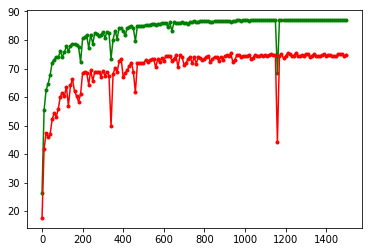

In [48]:
plt.plot(num_of_epoch, Training_acc_seq, 'g.-', num_of_epoch, Validation_acc_seq, 'r.-')
plt.show()

In [52]:
print("111")

111
